In [56]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt

from predict_qual import get_score
from skimage import img_as_float

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [57]:
im_path='01_dr.tif'
mask_path='01_dr_mask.tif'
threshold=0.5

In [60]:
im = img_as_float(np.array(Image.open(im_path).convert('L')))  # this can be a grayscale or binary prediction
im = im > threshold # this is binary for sure
mask = Image.open(mask_path).convert('L')  # this is a binary 0/255 image
mask = np.array(mask).astype(int)

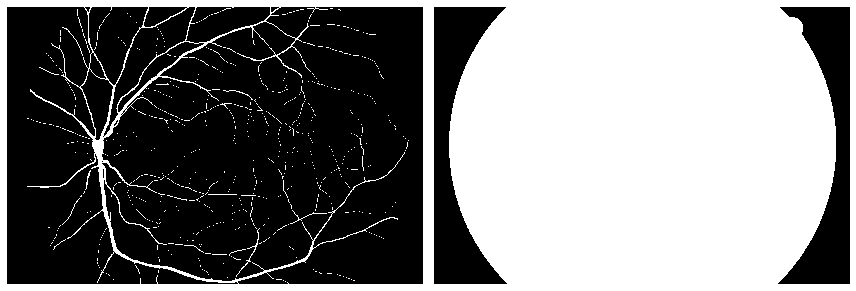

In [69]:
imshow_pair(im, mask)

In [70]:
get_score(im_path='01_dr.tif', mask_path='01_dr_mask.tif', threshold=0.5)

0.5295299291610718

In [98]:
from models.get_reg_model import get_arch
from utils.model_saving_loading import load_model
import torch
from torchvision import transforms as tr

def crop_to_fov(img, mask):
    mask = np.array(mask).astype(int)
    minr, minc, maxr, maxc = regionprops(mask)[0].bbox
    im_crop = Image.fromarray(np.array(img)[minr:maxr, minc:maxc])
    return im_crop

def prepare_single_image(im, mask):
    rsz = tr.Resize([512, 512], interpolation=2)
    tnsr = tr.ToTensor()
    transf = tr.Compose([rsz, tnsr])
    
    im_crop = crop_to_fov(im, mask)
    return transf(im_crop).unsqueeze(0)

In [103]:
model = get_arch('resnet18')
load_checkpoint = 'experiments/best_mse/'

In [106]:
model, _ = load_model(model, load_checkpoint, device='cpu', with_opt=False)
model.eval();

In [107]:
im1 = Image.open('01_dr.tif').convert('L')
mask1 = Image.open('01_dr_mask.tif').convert('L')

In [108]:
im_prep = prepare_single_image(im1, mask1)
torch.sigmoid(model(im_prep)).item()

0.9959654808044434

In [109]:
im2 = Image.open('12.png').convert('L')
mask2 = Image.open('12_mask.gif').convert('L')

In [110]:
im_prep = prepare_single_image(im2, mask2)
torch.sigmoid(model(im_prep)).item()

0.9915643930435181

In [127]:
im2 = Image.open('perfect.gif').convert('L')
im2_bin = np.array(im2)>100
mask2 = Image.open('01_mask.gif').convert('L')
im_prep = prepare_single_image(im2, mask2)
im_prep_bin = prepare_single_image(im2_bin, mask2)
torch.sigmoid(model(im_prep)).item(), torch.sigmoid(model(im_prep_bin)).item()

(0.9937378168106079, 0.7318292260169983)

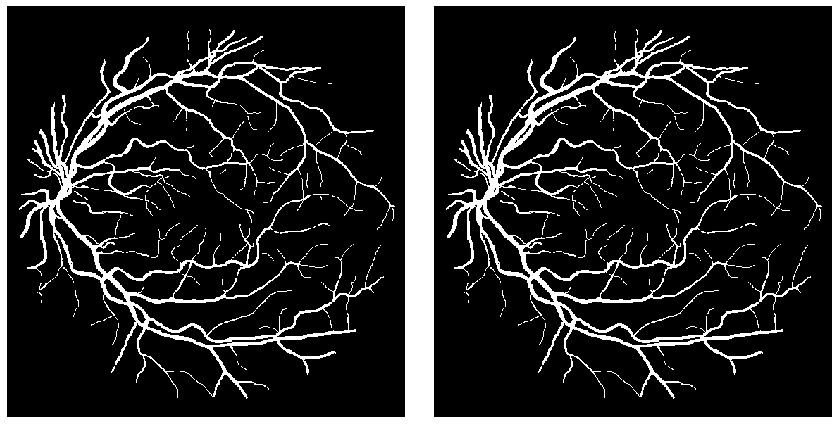

In [129]:
imshow_pair(im2, im2_bin)

In [130]:
im2 = Image.open('better.gif').convert('L')
im2_bin = np.array(im2)>100
mask2 = Image.open('01_mask.gif').convert('L')
im_prep = prepare_single_image(im2, mask2)
im_prep_bin = prepare_single_image(im2_bin, mask2)
torch.sigmoid(model(im_prep)).item(), torch.sigmoid(model(im_prep_bin)).item()

(1.0, 0.5536044239997864)

In [131]:
im2 = Image.open('worse.gif').convert('L')
im2_bin = np.array(im2)>100
mask2 = Image.open('01_mask.gif').convert('L')
im_prep = prepare_single_image(im2, mask2)
im_prep_bin = prepare_single_image(im2_bin, mask2)
torch.sigmoid(model(im_prep)).item(), torch.sigmoid(model(im_prep_bin)).item()

(1.0, 0.513837456703186)

In [146]:
csv_train = 'data/DRIVE/train.csv'
csv_val ='data/DRIVE/val.csv'
bs = 4
from utils.get_loaders import get_reg_loaders


train_loader, val_loader = get_reg_loaders(csv_path_train=csv_train, csv_path_val=csv_val, batch_size=bs,
                                           p_manual=0.5, p_nothing=0.1, max_deg_patches=100,
                                           max_patch_size=(64, 64), sim_method='mutual_info')

In [147]:
x = next(iter(train_loader))

In [148]:
torch.unique(x[0][0][0])

tensor([0., 1.])